**APPENDIX L**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/all_together - Copy.csv')
df.head()

,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0


In [ ]:
df['date'] = df[['year', 'month', 'day', 'hour']].apply(lambda row: f"{row['year']}-{row['month']}-{row['day']} {row['hour']}:00:00", axis=1)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.head()

,No,year,month,day,hour,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,1,2013,3,1,0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0,2013-03-01 04:00:00


In [ ]:

df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00
3,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,0.0,2013-03-01 03:00:00
4,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,0.0,2013-03-01 04:00:00


In [ ]:
df.sort_values(by='date', inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET,date
0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0,2013-03-01 00:00:00
35064,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,0.0,2013-03-01 00:00:00
1,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0,2013-03-01 01:00:00
35065,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7,0.0,2013-03-01 01:00:00
2,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0,2013-03-01 02:00:00


In [ ]:
df['date'].min(), df['date'].max()

(Timestamp('2013-03-01 00:00:00'), Timestamp('2017-02-28 23:00:00'))

In [ ]:
df.set_index('date', inplace=True)
df.head()

,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,TARGET
date,,,,,,,,,,,
2013-03-01 00:00:00,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,0.0
2013-03-01 00:00:00,6.0,13.0,7.0,300.0,85.0,-2.3,1020.8,-19.7,0.0,0.5,0.0
2013-03-01 01:00:00,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,0.0
2013-03-01 01:00:00,3.0,6.0,6.0,300.0,85.0,-2.5,1021.3,-19.0,0.0,0.7,0.0
2013-03-01 02:00:00,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,0.0


In [ ]:
X = df.drop('TARGET',axis=1)
y = df[['TARGET']]

X = np.nan_to_num(X)
y = np.nan_to_num(y)

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y1 = encoder.fit_transform(y)

Y = pd.get_dummies(y1).values

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,Y,test_size=0.25,random_state=0) 

In [ ]:
X_train.shape

(39088, 10, 1)

In [ ]:
y_train.shape

(39088, 3)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD,Adam

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from numpy import unique


model = Sequential()

model.add(Conv1D(64,2, activation="relu", input_shape=(10,1)))
model.add(MaxPooling1D())
model.add(Flatten())

model.add(Dense(3,activation='softmax'))

model.compile(Adam(lr=0.0004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=100, epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
313/313 [==============================] - 2s 5ms/step - loss: 7.1439 - accuracy: 0.6151 - val_loss: 0.6228 - val_accuracy: 0.7887
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5961 - accuracy: 0.7867 - val_loss: 1.2766 - val_accuracy: 0.6841
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 0.7026 - accuracy: 0.7734 - val_loss: 0.4755 - val_accuracy: 0.8140
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5030 - accuracy: 0.8023 - val_loss: 0.4695 - val_accuracy: 0.8147
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 0.4924 - accuracy: 0.8029 - val_loss: 0.4772 - val_accuracy: 0.8016
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5286 - accuracy: 0.7922 - val_loss: 0.4439 - val_accuracy: 0.8193
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 0.5212 - accuracy: 0.7987 - val_loss: 0.4561 - val_accuracy: 0.8141

In [ ]:
y_pred

array([[7.2066723e-13, 3.2059826e-02, 9.6794015e-01],
       [5.0760422e-02, 9.3045229e-01, 1.8787310e-02],
       [1.1718861e-04, 6.8111885e-01, 3.1876397e-01],
       ...,
       [1.2208226e-04, 9.4369447e-01, 5.6183483e-02],
       [6.1519539e-01, 3.8147071e-01, 3.3339185e-03],
       [1.1760678e-12, 6.3192523e-03, 9.9368072e-01]], dtype=float32)

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3251
           1       0.88      0.77      0.82      6527
           2       0.75      0.93      0.83      3252

    accuracy                           0.83     13030
   macro avg       0.83      0.85      0.83     13030
weighted avg       0.84      0.83      0.83     13030

[[2769  479    3]
 [ 465 5035 1027]
 [   6  232 3014]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.8302379125095932
Precision: 0.838179771206325
Recall: 0.8302379125095932
F1 Score: 0.8300782983182926




In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


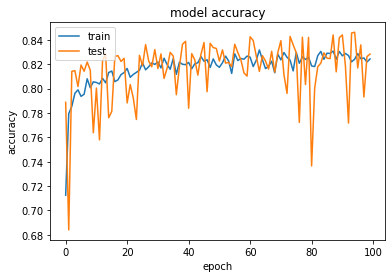

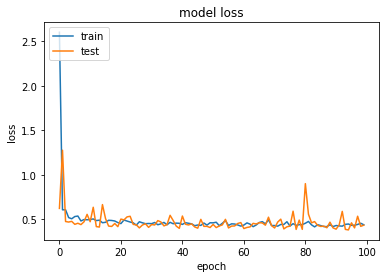

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam


model = Sequential()

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from numpy import unique


model = Sequential()

model.add(Conv1D(64,2, activation="relu", input_shape=(10,1)))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(3,activation='softmax'))

model.compile(SGD(lr=0.0004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
978/978 [==============================] - 2s 2ms/step - loss: 13.3116 - accuracy: 0.6916 - val_loss: 0.5580 - val_accuracy: 0.7323
Epoch 2/100
978/978 [==============================] - 2s 2ms/step - loss: 0.5130 - accuracy: 0.7876 - val_loss: 0.4739 - val_accuracy: 0.7993
Epoch 3/100
978/978 [==============================] - 2s 2ms/step - loss: 0.4889 - accuracy: 0.8013 - val_loss: 0.5036 - val_accuracy: 0.7776
Epoch 4/100
978/978 [==============================] - 2s 2ms/step - loss: 0.4782 - accuracy: 0.8084 - val_loss: 0.4683 - val_accuracy: 0.7896
Epoch 5/100
978/978 [==============================] - 2s 2ms/step - loss: 0.4620 - accuracy: 0.8109 - val_loss: 0.4573 - val_accuracy: 0.8056
Epoch 6/100
978/978 [==============================] - 2s 2ms/step - loss: 0.4623 - accuracy: 0.8097 - val_loss: 0.6217 - val_accuracy: 0.7452
Epoch 7/100
978/978 [==============================] - 2s 2ms/step - loss: 0.4571 - accuracy: 0.8155 - val_loss: 0.4369 - val_accuracy: 0.817

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
#from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))




              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3251
           1       0.78      0.88      0.83      6527
           2       0.90      0.65      0.75      3252

    accuracy                           0.81     13030
   macro avg       0.84      0.79      0.81     13030
weighted avg       0.82      0.81      0.81     13030

[[2733  514    4]
 [ 513 5775  239]
 [   3 1143 2106]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.8145817344589409
Precision: 0.8228735729653472
Recall: 0.8145817344589409
F1 Score: 0.8119695939320366




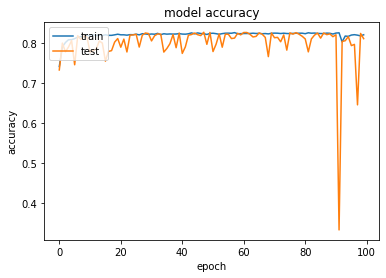

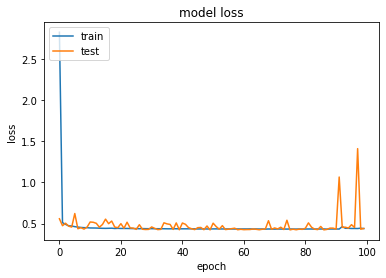

In [ ]:
 # summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam


model = Sequential()

from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris
from numpy import unique


model = Sequential()

model.add(Conv1D(64,2, activation="relu", input_shape=(10,1)))
model.add(MaxPooling1D())
model.add(Flatten())

model.add(Dense(3,activation='softmax'))

model.compile(RMSprop(lr=0.0004),'categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 9, 64)             192       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 963
Trainable params: 963
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,batch_size=100, epochs=100,verbose=1, validation_split=0.20)
y_pred = model.predict(X_test)


Epoch 1/100
313/313 [==============================] - 1s 3ms/step - loss: 45.9694 - accuracy: 0.5019 - val_loss: 1.2142 - val_accuracy: 0.7588
Epoch 2/100
313/313 [==============================] - 1s 3ms/step - loss: 1.6314 - accuracy: 0.7244 - val_loss: 1.2299 - val_accuracy: 0.7760
Epoch 3/100
313/313 [==============================] - 1s 3ms/step - loss: 1.4913 - accuracy: 0.7411 - val_loss: 2.2815 - val_accuracy: 0.6372
Epoch 4/100
313/313 [==============================] - 1s 3ms/step - loss: 1.5510 - accuracy: 0.7335 - val_loss: 2.1391 - val_accuracy: 0.6781
Epoch 5/100
313/313 [==============================] - 1s 3ms/step - loss: 1.5466 - accuracy: 0.7372 - val_loss: 2.7237 - val_accuracy: 0.5780
Epoch 6/100
313/313 [==============================] - 1s 3ms/step - loss: 1.4643 - accuracy: 0.7430 - val_loss: 0.8811 - val_accuracy: 0.8065
Epoch 7/100
313/313 [==============================] - 1s 3ms/step - loss: 1.5091 - accuracy: 0.7389 - val_loss: 1.7110 - val_accuracy: 0.716

In [ ]:
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82      3251
           1       0.93      0.59      0.72      6527
           2       0.68      0.96      0.79      3252

    accuracy                           0.77     13030
   macro avg       0.78      0.83      0.78     13030
weighted avg       0.81      0.77      0.76     13030

[[3088  152   11]
 [1200 3866 1461]
 [   9  135 3108]]


In [ ]:
import seaborn as sns
import pandas as pd
import datetime 
import calendar
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
 

# Model accuracy
print("\n")
print("Normal Predictor Values ===============================")
#print("model score: %.3f" % model.score(X_test, y_test))
print("Accuracy:",metrics.accuracy_score(y_test_class,y_pred_class))
print("Precision:",metrics.precision_score(y_test_class,y_pred_class, average='weighted'))
print("Recall:",metrics.recall_score(y_test_class,y_pred_class, average='weighted'))
print("F1 Score:",metrics.f1_score(y_test_class,y_pred_class, average='weighted'))
print("\n")



Normal Predictor Values ===============================
Accuracy: 0.7722179585571758
Precision: 0.8149699226406002
Recall: 0.7722179585571758
F1 Score: 0.7648828284329103




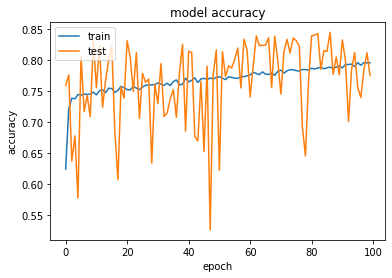

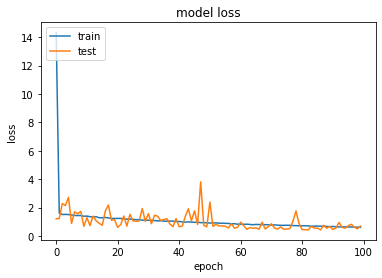

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
